In [7]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Create QEC code

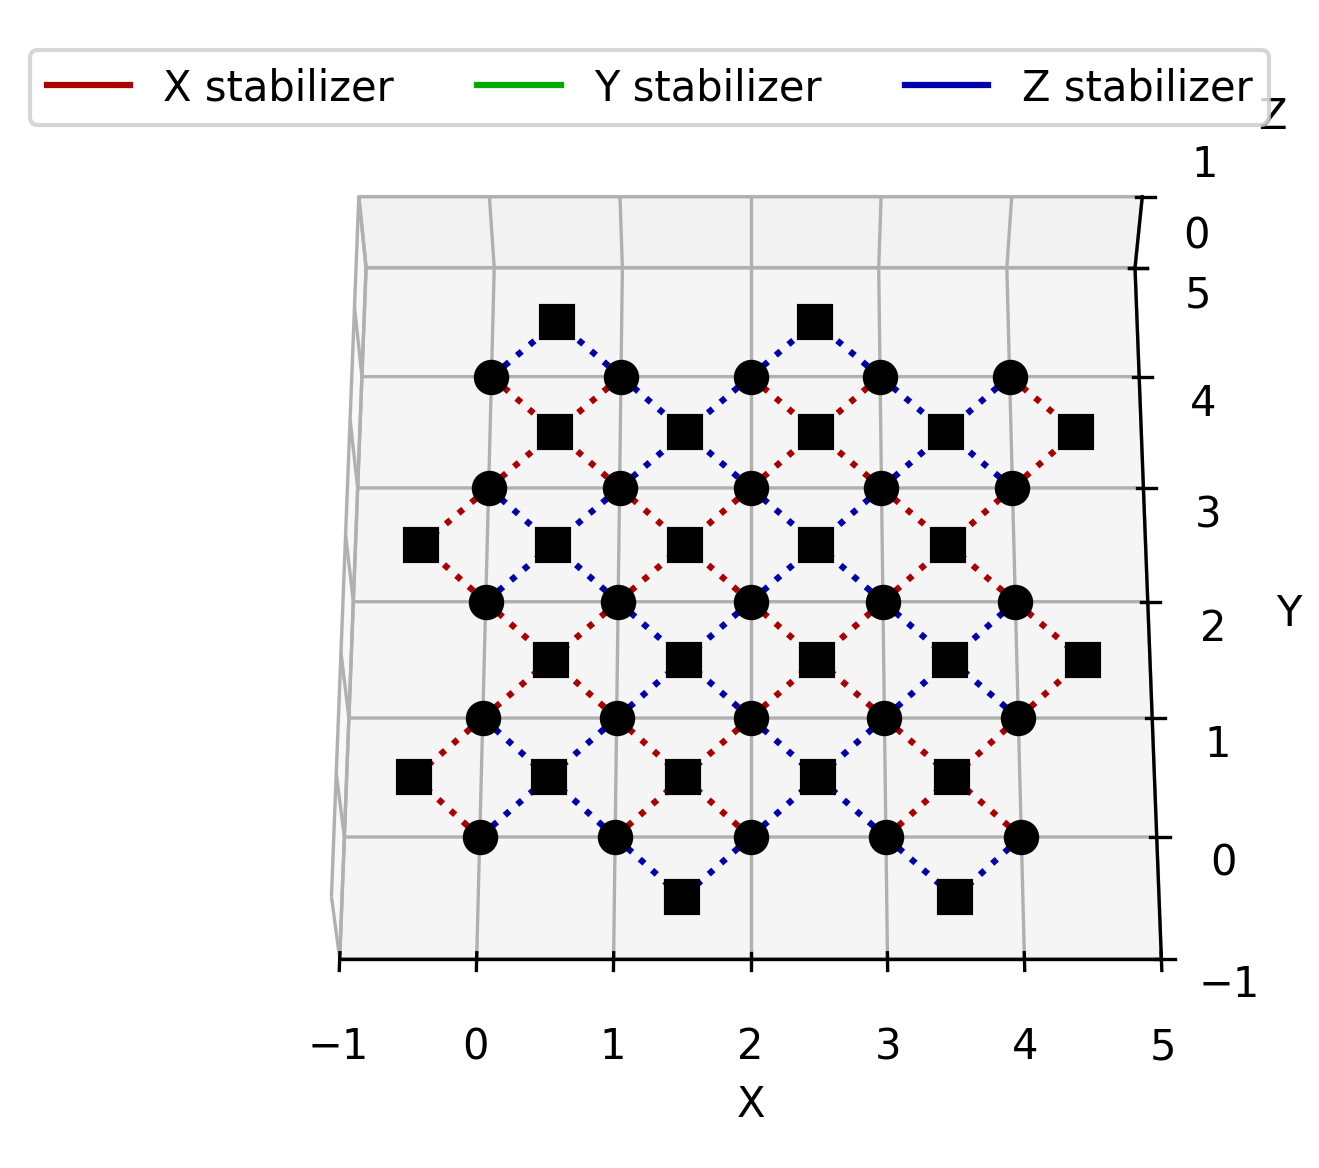

In [8]:
code_distance = 5
qec = QEC(surface_code_data(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
nsq, ndq = Mx.shape
qec.show();

# Load pre-trained NN decoder

In [9]:
params1 = load_NN("../trained_NN/NN_SC_D5_V1.json")
print(f"Layers: {[params1['weights'][0].shape[1]]+[bias.shape[0] for bias in params1['biases']]}")

params2 = load_NN("../trained_NN/NN_SC_D5_V2.json")
print(f"Layers: {[params2['weights'][0].shape[1]]+[bias.shape[0] for bias in params2['biases']]}")

Layers: [24, 200, 200, 100]
Layers: [24, 100, 50, 100]


# Functions for evaluating the NN

In [10]:
def NN_raw_to_correction(NN_output: jnp.ndarray) -> jnp.ndarray:
    """
    Normalize the NN output to represent probabilities 
    using the exponentiel of the values as their respective weights
    """
    # logits have values between zero and one
    logits = NN_output.reshape((4, NN_output.shape[0]//4))
    # Normalize so probabilities sum to one
    probabilities = logits / jnp.sum(logits, axis=0)
    return probabilities

NN_raw_to_correction_batch = jax.vmap(
    NN_raw_to_correction, 
    in_axes=0, 
    out_axes=0
)

In [11]:
def NN_correction_to_syndrome(NN_correction: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the probabilities of the NN_correction to calculate
    the probability that each of the stabilizers will be activated.

    This function does not take into account the correlation between
    stabilizers and merely evaluates each stabilizer independently
    """
    # Note: this is not matrix multiplication but element wise multiplication
    probabilities_x = Mx * NN_correction[1]
    probabilities_y = My * NN_correction[2]
    probabilities_z = Mz * NN_correction[3]
    probabilities = probabilities_x + probabilities_y + probabilities_z
    # Calculate probability that the stabilizer is activated
    p1 = jnp.zeros(probabilities.shape[0])
    for p in probabilities.T:
        #      0 -> 1    1 -> 1
        p1 = (1-p1)*p + p1*(1-p)
    return p1
    

NN_correction_to_syndrome_batch = jax.vmap(
    NN_correction_to_syndrome, 
    in_axes=(0, None, None, None), 
    out_axes=0
)

#### Cost function

In [12]:
def mse_loss_batch(syndromes: jnp.ndarray, params: dict, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the mean square to evaluate the performance of the NN
    """
    # Calculate the syndome probabilities produced by the correction given by the NN
    NN_raws = NN_batch(syndromes, params)
    NN_corrections = NN_raw_to_correction_batch(NN_raws)
    NN_syndromes = NN_correction_to_syndrome_batch(NN_corrections, Mx, My, Mz)
    # Return the mean square of the NN_syndromes vs the measured syndromes
    return jnp.mean((NN_syndromes - syndromes)**2) + 1E-20 # Add a small number so the loss never reaches zero as that seams to break the optimizer

mse_loss_batch_val_grad = jax.value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

# Run the NN

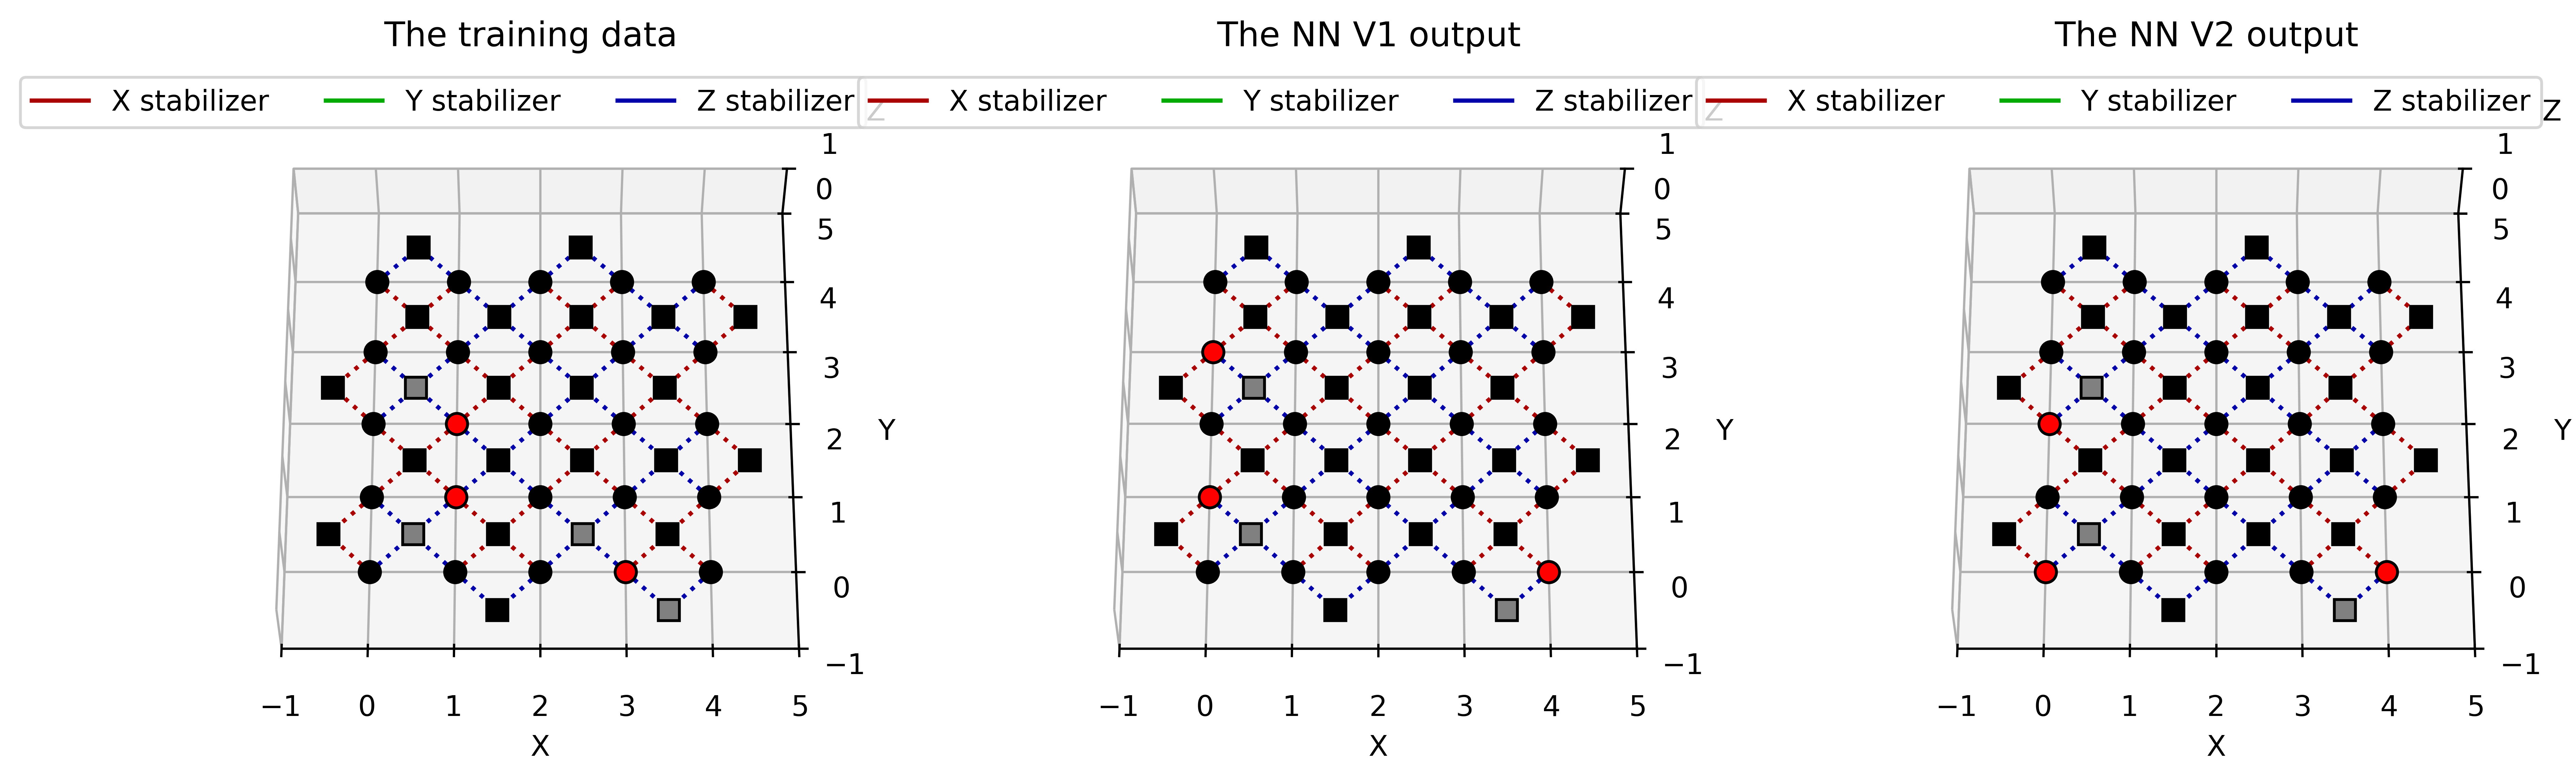

In [25]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = .02,
    py = .02,
    pz = .02,
    size = ndq,
    batch_size = batch_size,
    key = subkey
)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the neural network
NN_corrections = []
for params in [params1, params2]:
    NN_raw = NN_batch(syndromes, params)
    NN_correction = NN_raw_to_correction_batch(NN_raw)
    NN_syndrome = NN_correction_to_syndrome_batch(NN_correction, Mx, My, Mz)
    loss, gradient = mse_loss_batch_val_grad(syndromes, params, Mx, My, Mz)
    # print(f"\nThe loss of the NN is: {loss:.10f}")
    NN_corrections.append(NN_correction)

# Show the results
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': '3d'})
fig.set_dpi(600)
fig.set_figwidth(15)
fig.set_figheight(10)
qec.show(axis=ax[0], errors=errors[0], title="The training data")
qec.show(axis=ax[1], errors=NN_corrections[0][0].argmax(axis=0), title="The NN V1 output")
qec.show(axis=ax[2], errors=NN_corrections[1][0].argmax(axis=0), title="The NN V2 output")
# qec.show(axis=ax[1,0], errors=NN_corrections[2][0].argmax(axis=0), title="The NN V3 output")
# qec.show(axis=ax[1,1], errors=NN_corrections[3][0].argmax(axis=0), title="The NN V4 output")
# qec.show(axis=ax[1,2], title="The NN V4 (not yet trained)")
plt.show()

# Print the results
# print("Pauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction[0].T)]))
# print("\nSyndrome probabilities from the NN-predictions:\n"+'\n'.join(f"  {i}  {p:7.1%}" for i, p in enumerate(NN_syndrome[0])))